In [37]:
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
from scipy.stats import poisson
import scipy.stats as stats
from scipy.spatial import distance
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import community as community_louvain
import json

In [2]:
finestra = 1800

In [3]:
events_types = {"1a": {"start": "u1", "end":"u3" },\
                "1b": {"start": "u1", "end":"u3" },\
                "2": {"start": "u1", "end":"u3" },\
                "3a": {"start": "u1", "end":"u4" },\
                "3b": {"start": "u1", "end":"u4" },\
                "3c": {"start": "u1", "end":"u4" },\
                "4a": {"start": "u1", "end":"u4" },\
                "4b": {"start": "u1", "end":"u4" },\
                "4c": {"start": "u1", "end":"u4" },\
                "4d": {"start": "u1", "end":"u4" }}

In [4]:
events = pd.read_csv("../data/events_sign.csv")

In [5]:
for i1, row1 in events.iterrows():
    e1 = row1["evento"]
    end = row1[events_types[e1]["end"]]
    timestamp1 = row1["timestamp"]
    print(e1, end, timestamp1)
    break

1a 1849 1470574374


In [6]:
edges = []
for i1, row1 in events.iterrows():
    e1 = row1["evento"]
    end = row1[events_types[e1]["end"]]
    timestamp1 = row1["timestamp"]
    
    for i2, row2 in events.iterrows():
        timestamp2 = row2["timestamp"]
        e2 = row2["evento"]
        start = row2[events_types[e2]["start"]]

        if (timestamp2 > timestamp1 + finestra):
            break
        if(timestamp2 < timestamp1) or start!= end:
            continue
        edges.append((i1, i2))
        
    

In [7]:
edges_df = pd.DataFrame(edges, columns = ["source", "target"])
edges_df["weight"]=1

In [8]:
edges_df.to_csv("eventgraph.csv")

In [9]:
import networkx as nx

In [10]:
graph = nx.from_pandas_edgelist(edges_df,  source="source", target="target", edge_attr="weight", create_using=nx.DiGraph)

In [11]:
graph.remove_edges_from(nx.selfloop_edges(graph))
print("Number of nodes {}".format(graph.order()))
print("Number of edges {}".format(graph.size()))

Number of nodes 1358
Number of edges 3372


In [12]:
nx.is_directed_acyclic_graph(graph)

True

In [13]:
print("Density {}".format(nx.density(graph)))

Density 0.0018298182228623089


In [14]:
degrees = list(dict(graph.degree(weight="weight")).values())

print('Mean degree: \t'+ str(np.mean(degrees)))
print('Standard deviation: ' + str(np.std(degrees)))
print('Median: ' + str(np.median(degrees)))
print('iqr: ' + str(np.quantile(degrees, 0.75) - np.quantile(degrees, 0.25)))
print('Min: ' + str(np.min(degrees)))
print('Max: ' + str(np.max(degrees)))

Mean degree: 	4.9661266568483065
Standard deviation: 7.5548286418176005
Median: 2.0
iqr: 5.0
Min: 0
Max: 39


In [15]:
random_graph_erdos = nx.fast_gnp_random_graph(len(graph.nodes), nx.density(graph))
random_degrees = list(dict(random_graph_erdos.degree()).values())

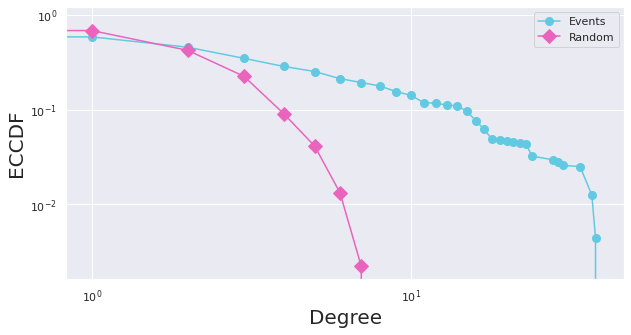

In [16]:
cdf = ECDF(degrees)
x = np.unique(degrees)
y = cdf(x)

cdf_random = ECDF(random_degrees)
x_random = np.unique(random_degrees)
y_random = cdf_random(x_random)
 
fig_cdf_fb = plt.figure(figsize=(10,5))
axes = fig_cdf_fb.gca()
axes.set_xscale('log')
axes.set_yscale('log')
axes.loglog(x,1-y,marker='o',ms=8, linestyle='-', label = "Events", color = "#61CAE2")
axes.loglog(x_random,1-y_random,marker='D',ms=10, linestyle='-', label="Random", color = "#EA63BD")
axes.legend()
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECCDF', size = 20)
plt.show()

In [17]:
nx.is_strongly_connected(graph),nx.is_weakly_connected(graph)

(False, False)

In [18]:
components_strong =  nx.strongly_connected_components(graph)
components_weak =  nx.weakly_connected_components(graph)

component_list_strong = list(components_strong)
component_list_weak = list(components_weak)

In [19]:
len(component_list_strong)

1358

In [20]:
len(component_list_weak)

555

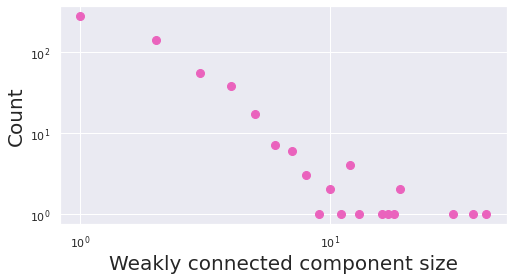

In [21]:
len_cc = [len(wcc) for wcc in component_list_weak]
counts = pd.Series(len_cc).value_counts().sort_index()

fig_gc = plt.figure(figsize=(8,4))
axes = fig_gc.gca()
axes.set_xscale('log')
axes.set_yscale('log')
axes.loglog(counts.index,counts.values,marker='o',ms=8, linestyle='None', color = "#EA63BD")
axes.set_xlabel('Weakly connected component size',size=20)
axes.set_ylabel('Count', size = 20)
plt.show()

In [22]:
print(f"{np.mean(degrees)/np.log(graph.order())}")

0.6884233655327194


# Community Detection

In [23]:
import networkx.algorithms.community as nx_comm
from collections import defaultdict
from networkx.algorithms.community import k_clique_communities

In [24]:
partion = community_louvain.best_partition(graph.to_undirected())

In [25]:
community = list(partion.items())
comm_df = pd.DataFrame(community, columns = ["node", "community"])

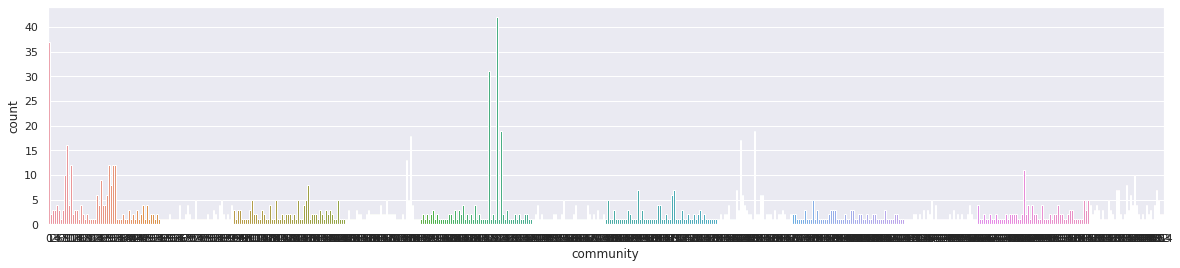

In [26]:
fig_gc = plt.figure(figsize=(20,4))
ax = sns.countplot(x="community", data=comm_df)

In [27]:
res = defaultdict(set)
for key, val in sorted(partion.items()):
    res[val].add(key)
res = list(res.values())

In [28]:
nx_comm.modularity(graph, res)

0.9297196998799684

## Overlapping

In [29]:
overlapp_comm = list(k_clique_communities(graph.to_undirected(), 3))

In [30]:
len(overlapp_comm)

141

In [31]:
overlapp_comm = [set(community) for community in overlapp_comm]

In [32]:
o_comm = []
for i, item in enumerate(overlapp_comm):
    [o_comm.append((node, i)) for node in list(item)]
o_comm_df = pd.DataFrame(o_comm, columns = ["node", "community"])

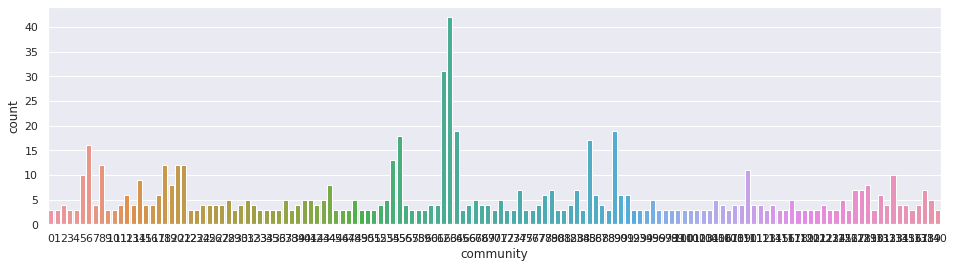

In [33]:
fig_gc = plt.figure(figsize=(16,4))
ax = sns.countplot(x="community", data=o_comm_df)

In [40]:
overlapp_comm = sorted(overlapp_comm, key = lambda x: len(x), reverse=True)
with open("overlapping_communities.txt", "w") as output:
    output.write(str(overlapp_comm))

In [45]:
res = sorted(res, key = lambda x: len(x), reverse=True)
with open("communities.txt", "w") as output:
    output.write(str(res))